In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function
from scipy.io import loadmat
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from handcrafted_descriptors.grid_classification import kernels as krn
from handcrafted_descriptors.grid_classification import accuracy_and_test as aat
from handcrafted_descriptors.grid_classification import utils
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import pickle
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV

In [7]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


## FUNCTIONS 

Functions to extract descriptors from matfile, build svm model and calculate accuracy

In [8]:
def train_model_and_calculate_accuracy(train_features,train_lab,test_features,test_lab): 
    scaler = StandardScaler()
    scaler.fit(train_features)

    #X_train = scaler.transform(train_features)
    X_train = train_features
    #X_test = scaler.transform(test_features)
    X_test = test_features
    
    clc = []
    acc = []
    prec = []
    rec = []
    for i in range(1,51):
        classifier = KNeighborsClassifier(n_neighbors=i) 
        classifier.fit(X_train, train_lab)
        clc.append(classifier)
        y_pred = classifier.predict(X_test)
        acc_temp = 0
        total = y_pred.shape[0]
        for j in range(y_pred.shape[0]):
            if y_pred[j]==test_lab[j]:
                acc_temp = acc_temp + 1
        precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, y_pred)
        prec.append(np.mean(precision))
        rec.append(np.mean(recall))
        acc.append(acc_temp/total)
    return acc, prec, rec,clc 

In [9]:

def load_descriptor_from_matfile(ft_path,lab_path):
    feat = loadmat(ft_path)
    feat = feat['features']
    lab = loadmat(lab_path)
    lab = lab['labels']
    return feat, lab


def define_and_train_svm(tr_feature, tr_lab, kernel_type, distance = None):
    if distance == None:
        print('here')
        svc  = OneVsRestClassifier(SVC(kernel = kernel_type,gamma = 'scale'),n_jobs = -1)
        svc = svc.fit(tr_feature, tr_lab)
        return svc, 0, np.zeros(tr_feature.shape[0])
    else:
        gram= krn.compute_gram_matrix(tr_feature,distance)
        mean = np.mean(gram[np.triu_indices(np.shape(tr_feature)[0])])
        gram = np.exp(-(gram/mean)) # generalized Gaussian kernel
        svc  = OneVsRestClassifier(SVC(kernel = 'precomputed'),n_jobs = -1)
        svc = svc.fit(gram,np.array(tr_lab))
        return svc, mean,gram



def equal(a,b):
    for i in range(a.shape[0]):
        if a[i]!=b[i]:
            return False
    return True





def test_accuracy(test_features,features,kernel,mean, test_label,svc):
    num_objects = features.shape[0]
    res = []
    prediction = []
    for i,ft in enumerate(test_features):
        if(i%200 ==0):
            print(i)

        pred = svc.predict(np.array([kernel(ft, features[num, :], mean) for num in range(num_objects)]).reshape(1, -1))
        prediction.append(pred[0])
        #print(i,": ",pred," : ",test_label[i])
        if(pred==test_label[i]):
            res.append(1)
        else:
            res.append(0)

    res = np.array(res).reshape(-1)
    return np.sum(res)/res.shape, np.array(prediction)


def calculate_and_plot_precision_recall(tst_lab, pred, species, directory, string):
    precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, pred)
    
    df = pd.DataFrame({"X":species, "precision":precision,"recall":recall,'f1score': fbeta})
    df.plot(x="X", y=["precision", "recall",'f1score'], kind="bar")
    plt.tight_layout()
    plt.savefig(directory +'precision_recall_class4class'+string+'.jpg')
    return np.mean(precision), np.mean(recall), np.mean(fbeta)



In [10]:
def search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'C': [ 1e0, 1e1, 1e2,1e3], 'gamma': [   0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0,skmetrics.accuracy_score(y_pred, tst_lab)

def search_for_best_poly(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'degree':[2,3,4,5,6,7],'C': [1e-3,1e-2, 1e-1, 1e0, 1e1, 1e2,1e3], 'gamma': [  0.00001,0.0001,0.001, 0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='degree'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0, skmetrics.accuracy_score(y_pred, tst_lab)

def create_and_save_confusion_matrix(model, tst_features, tst_lab, species, vw,director, name ):
    pred = model.predict(tst_features)
    df = utils.evaluated_prediction(pred, tst_lab, species)
    cm = utils.build_confusion_matrix(df, pred, tst_lab,species)
    fig=plt.figure(figsize=(30, 15))
    utils.plot_confusion_matrix(cm,species,name,director,normalize=True,title='Confusion matrix')
    plt.close()
    return pred

import matplotlib.pyplot as plt
def plot_and_save_knn(acc,prec,rec,direct):
    x1 = np.arange(1,51)
    plt.plot(x1, acc, label = "accuracy",color = 'r')
    plt.plot(x1,prec, label = 'precision')
    plt.plot(x1, rec, label = 'recall',color = 'g')
    plt.xlabel('number of neighbors')
    plt.ylabel('percentage (%)')
    plt.legend()
    plt.grid()
    plt.savefig(direct)
    plt.close()

accuracy = []
precision = []
recall = []
f1score = []

## MAIN

-----------------------------
200
------------------------------
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8675
-----------------------------
250
------------------------------
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8725
-----------------------------
300
------------------------------
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8725
-----------------------------
350
------------------------------
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8825
-----------------------------
400
------------------------------
Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8825
-----------------------------
450
------------------------------
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.87
-----------------------------
500
------------------------------
Best estimator found by grid search : 

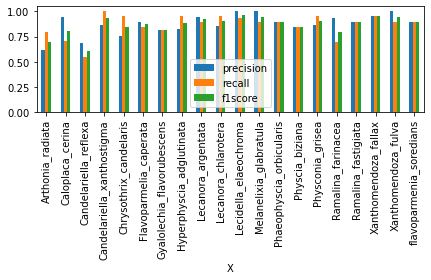

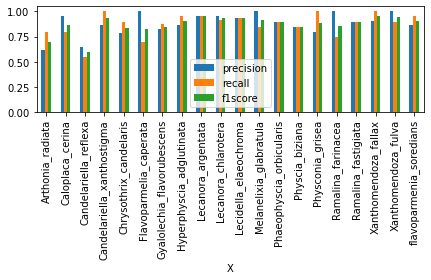

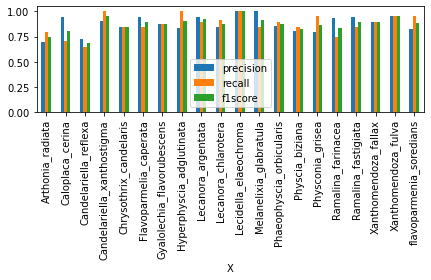

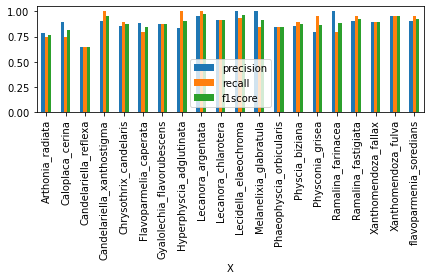

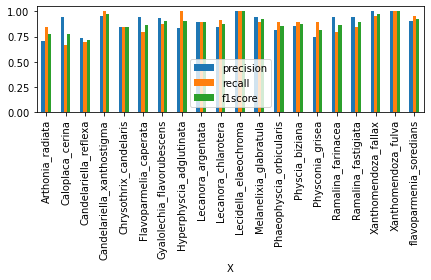

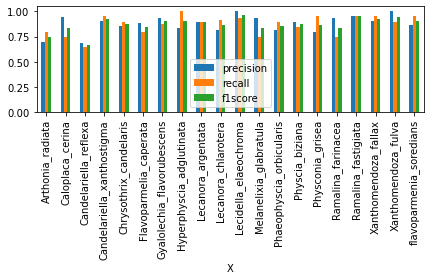

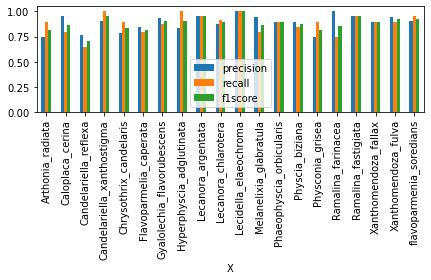

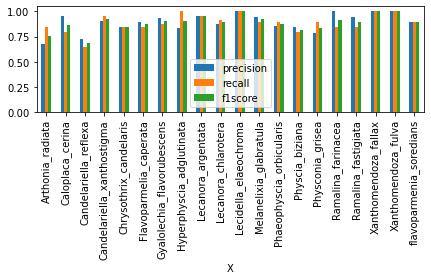

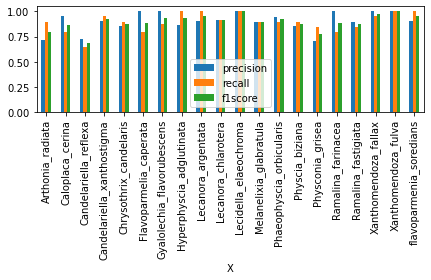

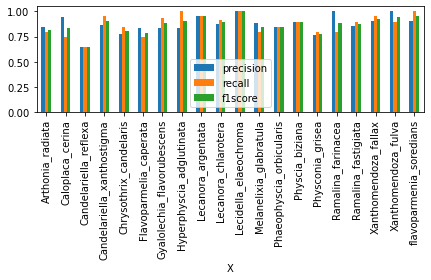

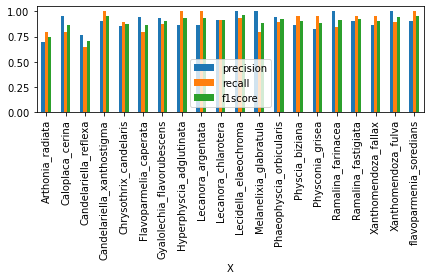

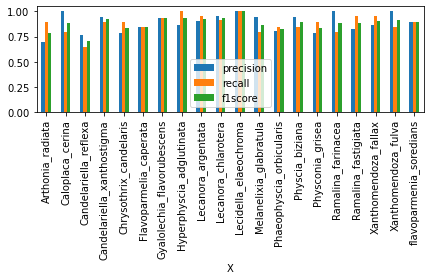

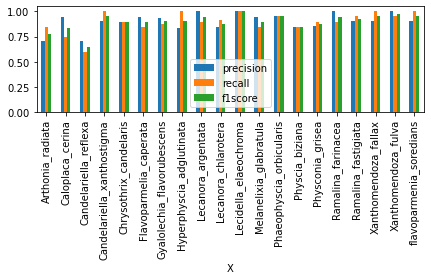

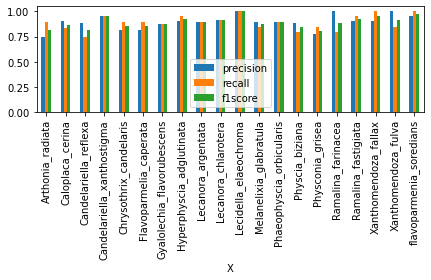

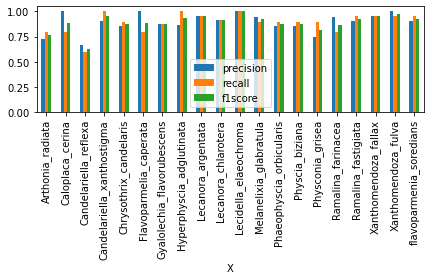

In [15]:

visual = [200, 250 ,300, 350 ,  400, 450, 500, 550, 600,650, 700,750,800,850,900]


accuracy = []
precision = []
recall = []
f1score = []


for i,vv in enumerate(visual):
    print('-----------------------------')
    print(vv)
    print('------------------------------')
    



    trf = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/training_features.mat'
    trlab = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/training_lab_features.mat'

    tstf = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/testing_features.mat'
    tstlab = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/testing_lab_features.mat'



    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    name = "phow_4_"+str(vv)+'opponent_'
    direc = "results/phow_8_opponent/confusion_matrix/"
    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, vv,direc,name)
    
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, 'results/phow_8_opponent/precision_recall/', 'phow_6_' + str(vv) +'_')


    #knnacc, knnprec, knnrec ,_ = train_model_and_calculate_accuracy(training_feat,tr_lab,tst_features,tst_lab)
    
    #classifier = KNeighborsClassifier(n_neighbors=1) 
    #classifier.fit(training_feat,tr_lab)
    #pred = create_and_save_confusion_matrix(classifier, tst_features, tst_lab, species, vv,'results/phow_4_opponent/knn/','conf_mat_knn_' + str(vv) + '.jpg')
    
    
    
    #plot_and_save_knn(knnacc, knnprec, knnrec,'results/phow_4_opponent/knn/plotting_' + str(vv) + '.jpg')
    
    

    
    accuracy.append(np.mean(score))
    precision.append(np.mean(a))
    recall.append(np.mean(b))
    #f1score.append(np.mean(c))

In [ ]:
# plot precision recall and accuracy 

import matplotlib.pyplot as plt
x1 = [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
plt.plot(x1, accuracy, label = "accuracy",color = 'r')
plt.plot(x1,precision, label = 'precision')
plt.plot(x1, recall, label = 'recall',color = 'g')
plt.xticks(x1)
plt.xlabel('number of words')
plt.ylabel('percentage %')
plt.grid()
plt.legend()
plt.savefig('results/phow_6_opponent/total/acc_prec_rec.jpg')

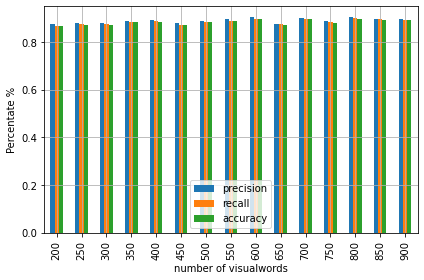

In [16]:
x1 = [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
df = pd.DataFrame({"X":x1, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('number of visualwords')
plt.ylabel('Percentate %')
plt.tight_layout()
#plt.savefig('results/phow_6_opponent/total/acc_prec_rec_bar.jpg')

In [ ]:
from scipy.io import savemat,loadmat

# VARY THE GRIDSIZE

In [ ]:
visual = [4,6,8,12,16,32,64]

precision = []
recall = []
accuracy = []
f1score = []

for i,vv in enumerate(visual):
    print('-----------------------------')
    print(vv)
    print('------------------------------')
    



    trf = '../../../features_for_python_' + str(vv) + '_opponent_phow/phowf_' + str(vv) + '_500_rbf/training_features.mat'
    trlab = '../../../features_for_python_' + str(vv) + '_opponent_phow/phowf_' + str(vv) + '_500_rbf/training_lab_features.mat'

    tstf = '../../../features_for_python_' + str(vv) + '_opponent_phow/phowf_' + str(vv) + '_500_rbf/testing_features.mat'
    tstlab = '../../../features_for_python_' + str(vv) + '_opponent_phow/phowf_' + str(vv) + '_500_rbf/testing_lab_features.mat'



    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    name = "phow_"+str(vv)+'_500_opponent_'
    direc = "results/results/phow_500/confusion_matrix/"
    pred = create_and_save_confusion_matrix(tst_features, tst_lab, species, vv,direc,name)
    
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, 'results/grid_results/phow_500/precision_recall/', 'phow_' + str(vv) +'_500_opponent')
    

    
    #accuracy.append(np.mean(score))
    #precision.append(np.mean(a))
    #recall.append(np.mean(b))
    #f1score.append(np.mean(c))

In [ ]:
df = pd.DataFrame({"X":visual, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('density of the grid (in pixel)')
plt.ylabel('Percentate %')
plt.tight_layout()
plt.savefig('results/grid_results/phow_500/total/acc_prec_rec.jpg')

# TRY TO BUILD A MASK 


In [ ]:
# first we want a specific svm---> take 4 grid 400 opponent

trf = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(4) + '_400_rbf/training_features.mat'
trlab = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(4) + '_400_rbf/training_lab_features.mat'

tstf = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(4) + '_400_rbf/testing_features.mat'
tstlab = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(4) + '_400_rbf/testing_lab_features.mat'

training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)
tr_lab = tr_lab -1
tst_lab = tst_lab -1

svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)



In [ ]:

tt = 70

pred = svm.predict([tst_features[tt].reshape(-1)])[0]
print(species[pred])
print(species[tst_lab[tt][0]])

In [ ]:
cr = loadmat('robustness/image_0/desc/descriptors.mat')
cr = cr['or_featureVector']
svm.predict([cr.reshape(-1)])[0]

In [ ]:
ff = loadmat('robustness/image_3/desc/direc.mat')

In [ ]:
immagini = ['original','I_90','I_180','I_270','I_g2_','I_g4_','I_g6_','I_g8_','I_g10_','I_il20_',
           'I_il60_','I_il100_']


imgd_dsc = {}
imgd_dsc['original'] = 'descriptors.mat'
imgd_dsc['I_90'] = 'I_90_descriptors.mat'
imgd_dsc['I_180'] = 'I_180_descriptors.mat'
imgd_dsc['I_270'] = 'I_270_descriptors.mat'

imgd_dsc['I_g2_'] = 'I_g2_descriptors.mat'
imgd_dsc['I_g4_'] = 'I_g4_descriptors.mat'
imgd_dsc['I_g6_'] = 'I_g6_descriptors.mat'
imgd_dsc['I_g8_'] = 'I_g8_descriptors.mat'
imgd_dsc['I_g10_'] = 'I_g10_descriptors.mat'

imgd_dsc['I_il20_'] = 'I_il20_descriptors.mat'
imgd_dsc['I_il60_'] = 'I_il60_descriptors.mat'
imgd_dsc['I_il100_'] = 'I_il100_descriptors.mat'


labels_x = {}


labels_x['original'] = 'original image'
labels_x['I_90'] = '90° rotation'
labels_x['I_180'] = '180° rotation'
labels_x['I_270'] = '270° rotation'


labels_x['I_g2_'] = 'smooth with sigma = 0.3'
labels_x['I_g4_'] = 'smooth with sigma = 0.6'
labels_x['I_g6_'] = 'smooth with sigma = 0.1'
labels_x['I_g8_'] = 'smooth with sigma = 1.3'
labels_x['I_g10_'] = 'smooth with sigma = 1.6'

labels_x['I_il20_'] = 'add 20 to every pixel'
labels_x['I_il60_'] = 'add 60 to every pixel'
labels_x['I_il100_'] = 'add 100 to every pixel'

desc_path = 'robustness/image_3/desc'
im_pth = 'robustness/image_3/image'
fig, m_axs = plt.subplots(3, 4, figsize = (25, 15))
i = 0
j = 0
for  immg in  immagini:
    # desc 
    descriptor_pth = os.path.join(desc_path,imgd_dsc[immg])
    cr = loadmat(descriptor_pth)
    if(imgd_dsc[immg] == 'descriptors.mat'):
        cr = cr['or_featureVector']
    else:
        cr = cr['featureVector']     
    prd = svm.predict([cr.reshape(-1)])[0]
    temp = species[prd]
    pp = os.path.join(im_pth, immg + '.jpg')
    im = cv2.imread(pp)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    m_axs[i,j].imshow(im)
    m_axs[i,j].set_title(labels_x[immg] + ': ' + temp,color=("green" if temp=='Candelariella_xanthostigma' else "red"))
    m_axs[i,j].axis('off')
    #m_axs[i,j].set_xlabel(labels_x[im])
    j = j + 1
    if(j > 3):
        i = i + 1
        j = 0
plt.savefig('results/robust/Candelariella_xanthostigma_robust.jpg')

## VALUTAZIONE ROBUSTEZZA

In [ ]:
feat_right = []
labels = []
for i in range(tst_features.shape[0]):
    tst = tst_features[i]
    pred = svm.predict([tst.reshape(-1)])[0]
    if pred == tst_lab[i][0]:
        temp = species[tst_lab[i][0]] + '_' + str(i)
        feat_right.append(i+1)
        labels.append(tst_lab[i][0])

c = {'a': feat_right, 'b': labels}
from scipy.io import savemat
savemat("images_to_be_augmented.mat",c)
    
    

In [ ]:
len(feat_right)/tst_features.shape[0]

In [ ]:
def create_predicted_mask(c):
    mask = np.zeros((10,10))
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            r = svm.predict([c[i,j,:]])
            mask[i,j] = r[0]
    return mask
            

In [ ]:
mask = create_predicted_mask(c)

In [ ]:
#pth_imm = '../../../images_matlab_test/text_image_N1'
#immagine = cv2.imread(pth_imm + '/text_image_N1.jpg')
#immagine = cv2.cvtColor(immagine, cv2.COLOR_RGB2BGR)
#plt.imshow(immagine)

In [ ]:
dscpth = os.path.join(pth_imm,'dsc')
dsc_list = os.listdir(dscpth )

In [ ]:
for i in range(7):
    for j in range(7):
        stringa = 'crops_' + str(i) + '_' + str(j) + '.mat'
        descrittore = os.path.join(dscpth,stringa)
        desc = loadmat(descrittore)
        desc = desc['featureVector']
        desc = desc.reshape(-1)
        print(svm.predict([desc]))

### OTHER STUFF

In [ ]:
cc = loadmat('scale_robustness/features_400.mat')
dd = loadmat('scale_robustness/labels.mat')

In [ ]:
features= cc['feat']
labs = dd['labs']
labs = labs -1 

In [ ]:
for i in range(features.shape[0]):
    ft = features[i]
    lab = labs[i][0]
    print('.................')
    print( svm.predict([ft.reshape(-1)])[0] == lab)


## K-NN



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(training_feat)

X_train = scaler.transform(training_feat)
X_test = scaler.transform(tst_features)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def train_model_and_calculate_accuracy(train_features,train_lab,test_features,test_lab): 
    scaler = StandardScaler()
    scaler.fit(train_features)

    X_train = scaler.transform(train_features)
    X_test = scaler.transform(test_features)
    clc = []
    acc = []
    prec = []
    rec = []
    for i in range(1,51):
        classifier = KNeighborsClassifier(n_neighbors=i) 
        classifier.fit(X_train, train_lab)
        clc.append(classifier)
        y_pred = classifier.predict(X_test)
        acc_temp = 0
        total = y_pred.shape[0]
        for j in range(y_pred.shape[0]):
            if y_pred[j]==test_lab[j]:
                acc_temp = acc_temp + 1
        precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, y_pred)
        prec.append(np.mean(precision))
        rec.append(np.mean(recall))
        acc.append(acc_temp/total)
    return acc, prec, rec,clc 

In [ ]:
acc,prec, rec, classif = train_model_and_calculate_accuracy(training_feat, tr_lab, tst_features, tst_lab)

In [ ]:
import matplotlib.pyplot as plt
x1 = np.arange(1,51)
plt.plot(x1, acc, label = "accuracy",color = 'r')
plt.plot(x1,prec, label = 'precision')
plt.plot(x1, rec, label = 'recall',color = 'g')
plt.xlabel('number of neighbors')
plt.ylabel('percentage (%)')
plt.legend()
plt.grid()
plt.savefig('results/grid_results/k-nearest_neighbor_total.jpg')